# Open Market Backtesting

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = False
datapath='../data/'

if daily:
    d = 3000
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date='1965-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df = Data(d=d, start_date=start_date, datapath=datapath, filename=filename, caps_table=caps_table, returns_table=returns_table)

#### Estimating $a$ and Computing Optimal Strategy

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


[-1.10904409 -1.10717106 -1.1053012  -1.1034345  -1.10157095]


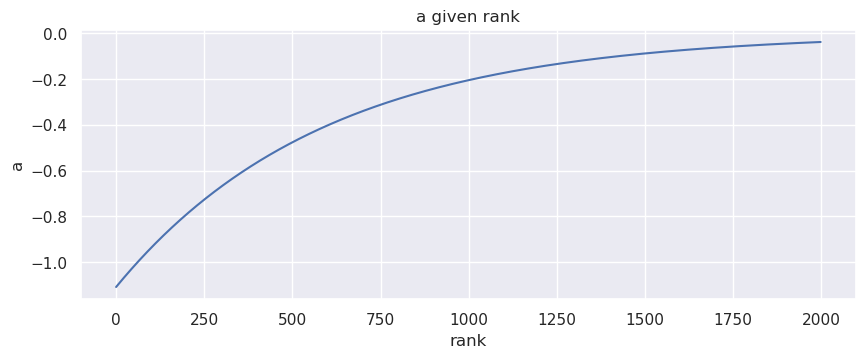

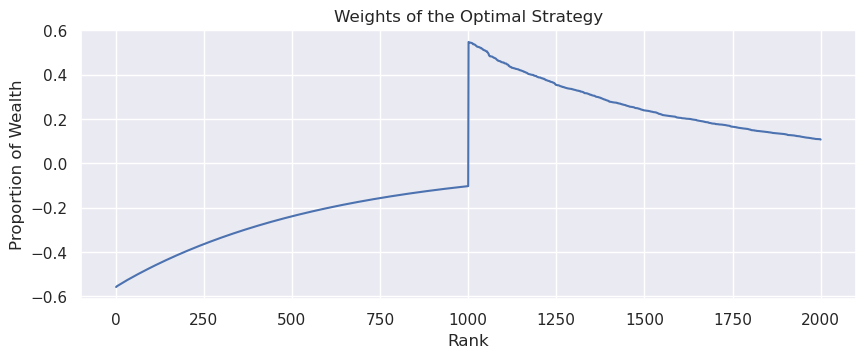

In [3]:
# Estimate a
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_parameter = 1
smooth_a = False

a = estimate_a(df.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
print(a[:5])
plot_a(a[:-1])

# Compute Strategy
setting = 'mixed'
N = 1000
plot_date = '2013-03-28'

strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df.weights_by_rank)
plot_strategy(strategy, plot_date)

#### Compute Optimal Strategy and Backtest

In [4]:
backtest = Backtest(strategy=strategy, weights_permno_by_rank=df.weights_permno_by_rank, returns_by_permno=df.returns_by_permno)

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:44: RuntimeWarning: overflow encountered in double_scalars
  cumulative_ret *= ret


The average return each month was 1.3493
The final cumulative interest in the period was inf


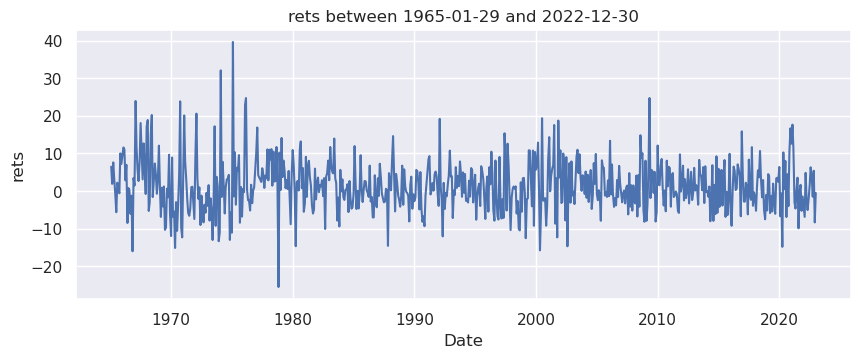

/home/pedro/miniconda3/envs/math_fin/lib/python3.11/site-packages/matplotlib/ticker.py:2101: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


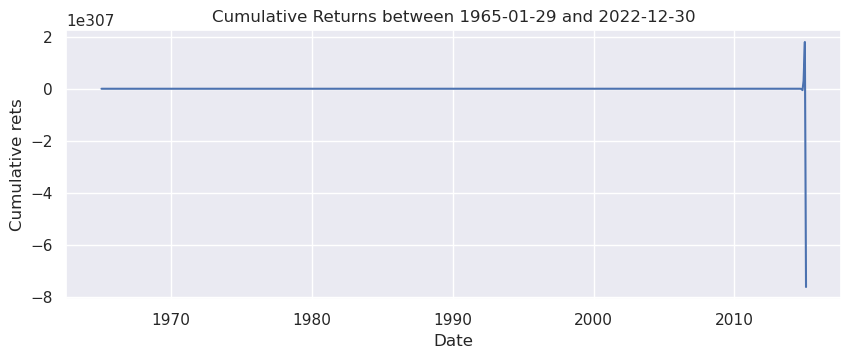

In [5]:
backtest.set_strategy(strategy)
backtest.run()

print('The average return each month was',round(np.mean(backtest.rets), 4))
print('The final cumulative interest in the period was', round(np.mean(backtest.cumulative_rets[-1]), 4))
backtest.plot_rets()
backtest.plot_cumulative_rets()

### Backtest log wealth

To backtest the log wealth I used the following formula:
$$
\log V = \pi^{\top} \frac {dX_t}{X_t} - \frac 1 2 \pi^{\top} d[X,X]\pi
$$

Which numerically translates to
$$
\log V_T = \sum_{t=0}^T \left [ \pi^{\top}(t) \frac {X_t - X_{t-1}}{X_{t}} - \sum_{i,j}\frac 1 2 \pi_i(t) d[X_i,X_j]\pi_j(t) \right] \\ 
d[X_i, X_j](t) = (X_i(t)-X_i(t-1)) (X_j(t)-X_j(t-1))
$$

In [6]:
backtest.set_strategy(strategy)

In [7]:
backtest.backtest_log_wealth()

[0.0, 4.3357574678319395, 5.537302587615471, 12.78036605591769, 16.286877985046576]
[0.0, 4.3357574678319395, 1.201545119783532, 7.2430634683022195, 3.506511929128885]
The average return each month was 1.5359674666652276e+21


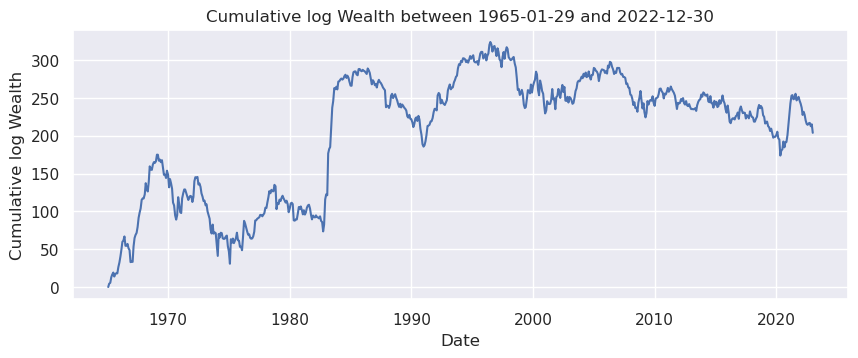

In [8]:
print(backtest.cumulative_log_wealths[0:5])
print(backtest.log_wealths[0:5])

wealth_ratios = np.exp(backtest.log_wealths)
average_wealth_ratio = np.mean(wealth_ratios)

print('The average return each month was',round(average_wealth_ratio, 4))

# backtest.plot_log_wealth()
backtest.plot_cumulative_log_wealth()